# Comparación de Modelos: AE vs VAE

## Pipeline de ejecución

Para ejecutar esta comparación correctamente, sigue estos pasos:

1. **Notebook 04**: `04_resilience_latent_clustering_h2_valley.ipynb`
   - Entrena el modelo **Autoencoder (AE)** determinista
   - Ejecuta **todas las celdas** hasta el final
   - La última celda exporta los embeddings y métricas a `data/autoencoder_trained_v2/`

2. **Notebook 05**: `05_resilience_vae.ipynb`
   - Entrena el modelo **Variational Autoencoder (VAE)** probabilístico
   - Ejecuta **todas las celdas** hasta el final
   - La última celda exporta los embeddings y métricas a `data/autoencoder_trained_v2/`

3. **Notebook 06** (este notebook):
   - Carga los embeddings exportados por los notebooks anteriores
   - Realiza la comparación cuantitativa de ambos modelos
   - Recomienda qué modelo usar para el análisis de resiliencia

## Archivos generados

Después de ejecutar notebooks 04 y 05, encontrarás en `data/autoencoder_trained_v2/`:

```
ae_latents_test.npz         # Embeddings z del AE
ae_metrics_test.npz         # Métricas de resiliencia AE
ae_model_latent7_test.pth   # Modelo AE entrenado (PyTorch)

vae_latents_test.npz        # Embeddings μ,logvar del VAE
vae_metrics_test.npz        # Métricas de resiliencia VAE
vae_model_latent8_beta1.0_test.pth  # Modelo VAE entrenado (PyTorch)
```

In [25]:
import os, pickle, re, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, wilcoxon, kruskal
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 120

SEED = 42
np.random.seed(SEED)

# Rutas base (ajusta si difieren)
BASE_DIR = "/home/aninotna/magister/tesis/justh2_pipeline"
DATA_DIR = os.path.join(BASE_DIR, "data/autoencoder_tensors")
MODE = "test"

PATH_SSP245       = os.path.join(DATA_DIR, f"tensors_ssp245_splits_{MODE}.npz")
PATH_SSP370       = os.path.join(DATA_DIR, f"tensors_ssp370_splits_{MODE}.npz")
PATH_SSP585       = os.path.join(DATA_DIR, f"tensors_ssp585_splits_{MODE}.npz")
PATH_SSP245_ORIG  = os.path.join(DATA_DIR, f"tensors_ssp245_splits_{MODE}_ORIGINAL.npz")
PATH_SSP370_ORIG  = os.path.join(DATA_DIR, f"tensors_ssp370_splits_{MODE}_ORIGINAL.npz")
PATH_SSP585_ORIG  = os.path.join(DATA_DIR, f"tensors_ssp585_splits_{MODE}_ORIGINAL.npz")
PATH_FEATURE_NAMES= os.path.join(DATA_DIR, f"feature_names_{MODE}.csv")
PATH_METADATA     = os.path.join(DATA_DIR, f"metadata_{MODE}.pkl")

def load_npz_stack(path, is_original=False):
    d = np.load(path)
    if is_original:
        X = np.vstack([d["X_train_original"], d["X_val_original"], d["X_test_original"]])
    else:
        X = np.vstack([d["X_train"], d["X_val"], d["X_test"]])
    idx = np.concatenate([d["train_idx"], d["val_idx"], d["test_idx"]])
    return X, idx

feature_names = pd.read_csv(PATH_FEATURE_NAMES)["feature_name"].tolist()

with open(PATH_METADATA, "rb") as f:
    meta = pickle.load(f)

mask       = meta["mask"]
spat_info  = meta["spatial_info"]
splits     = meta["splits"]

# coords ordenadas como en stack
lat = spat_info["lat"]; lon = spat_info["lon"]
LAT_GRID, LON_GRID = np.meshgrid(lat, lon, indexing="ij")
lat_flat = LAT_GRID[mask]; lon_flat = LON_GRID[mask]
all_idx = np.concatenate([splits["train_idx"], splits["val_idx"], splits["test_idx"]])
coords_df = pd.DataFrame({"lat": lat_flat[all_idx], "lon": lon_flat[all_idx], "pixel_id": np.arange(len(all_idx))})

print("✓ setup listo")


✓ setup listo


In [28]:
# normalizados (para embeddings)
X245n, _ = load_npz_stack(PATH_SSP245, is_original=False)
X370n, _ = load_npz_stack(PATH_SSP370, is_original=False)
X585n, _ = load_npz_stack(PATH_SSP585, is_original=False)

# originales (para H2)
X245o, _ = load_npz_stack(PATH_SSP245_ORIG, is_original=True)
X370o, _ = load_npz_stack(PATH_SSP370_ORIG, is_original=True)
X585o, _ = load_npz_stack(PATH_SSP585_ORIG, is_original=True)

def cols_for_decades(names, decades):
    pat = re.compile(r"_decadal_(?:mean|max|min)_(\d{4})$")
    idx = []
    for j, n in enumerate(names):
        m = pat.search(n)
        if m and int(m.group(1)) in decades: idx.append(j)
    return idx

def non_decadal_cols(names):
    return [j for j, n in enumerate(names) if "_decadal_" not in n]

BASE_DECADES   = [2020]
TARGET_DECADES = [2040, 2060, 2080]  # ajusta si quieres

base_idx = cols_for_decades(feature_names, BASE_DECADES)
tgt_idx  = cols_for_decades(feature_names, TARGET_DECADES)
non_idx  = non_decadal_cols(feature_names)

def build_block(Xn):
    BASE = np.hstack([Xn[:, base_idx], Xn[:, non_idx]])
    TGT  = np.hstack([Xn[:, tgt_idx],  Xn[:, non_idx]])
    return BASE, TGT

B245, T245 = build_block(X245n)
B370, T370 = build_block(X370n)
B585, T585 = build_block(X585n)

# Estrategia alternativa: usar columna estática de CF y calcular diferencia entre escenarios
# drop_370 = (CF_245 - CF_370) / CF_245  →  degradación de SSP245 a SSP370
# drop_585 = (CF_245 - CF_585) / CF_245  →  degradación de SSP245 a SSP585

# Buscar columna estática de CF
cf_idx = None
for j, name in enumerate(feature_names):
    if name == "calliope_cf_mean":
        cf_idx = j
        break

if cf_idx is None:
    raise ValueError("No se encontró columna 'calliope_cf_mean'")

print(f"Usando columna estática: [{cf_idx}] {feature_names[cf_idx]}")

# Extraer CF por escenario (mismo punto espacial, diferentes escenarios climáticos)
CF_245 = X245o[:, cf_idx]
CF_370 = X370o[:, cf_idx]
CF_585 = X585o[:, cf_idx]

# Calcular degradación relativa respecto a SSP245 (escenario moderado como baseline)
# drop > 0: El CF disminuye en escenarios más severos (menor resiliencia)
drop_245 = np.zeros_like(CF_245)  # SSP245 como referencia (sin degradación)
drop_370 = (CF_245 - CF_370) / (CF_245 + 1e-8)
drop_585 = (CF_245 - CF_585) / (CF_245 + 1e-8)

# Clip para evitar valores extremos
drop_245 = np.clip(drop_245, -5, 5)
drop_370 = np.clip(drop_370, -5, 5)
drop_585 = np.clip(drop_585, -5, 5)

print(f"CF por escenario:")
print(f"  SSP245: min={CF_245.min():.3f}, max={CF_245.max():.3f}, mean={CF_245.mean():.3f}")
print(f"  SSP370: min={CF_370.min():.3f}, max={CF_370.max():.3f}, mean={CF_370.mean():.3f}")
print(f"  SSP585: min={CF_585.min():.3f}, max={CF_585.max():.3f}, mean={CF_585.mean():.3f}")

print("✓ datos cargados y segmentados")


Usando columna estática: [3] calliope_cf_mean
CF por escenario:
  SSP245: min=0.180, max=0.253, mean=0.225
  SSP370: min=0.179, max=0.252, mean=0.224
  SSP585: min=0.182, max=0.255, mean=0.227
✓ datos cargados y segmentados


In [29]:
# Diagnóstico: buscar TODAS las columnas relacionadas con H2
print("Columnas de H2 encontradas:")
h2_cols = [i for i, name in enumerate(feature_names) if 'h2' in name.lower() or 'calliope' in name.lower()]
for idx in h2_cols:
    print(f"  [{idx}] {feature_names[idx]}")

print(f"\nTotal: {len(h2_cols)} columnas relacionadas con H2/Calliope")

Columnas de H2 encontradas:
  [0] calliope_h2_prod_ton
  [1] calliope_lcoh_usd_kg
  [2] calliope_cap_electrolyzer_mw
  [3] calliope_cf_mean

Total: 4 columnas relacionadas con H2/Calliope


In [30]:
# Cargar embeddings desde archivos exportados por notebooks 04 y 05
OUTPUT_DIR = os.path.join(BASE_DIR, "data/autoencoder_trained_v2")

# Cargar embeddings AE
ae_latents_path = os.path.join(OUTPUT_DIR, f"ae_latents_{MODE}.npz")
if not os.path.exists(ae_latents_path):
    raise FileNotFoundError(f"⚠️ No encontré {ae_latents_path}\nEjecuta primero la última celda del notebook 04 para exportar.")

ae_data = np.load(ae_latents_path)
zB245 = ae_data["zB245"]
zB370 = ae_data["zB370"]
zB585 = ae_data["zB585"]
z_245 = ae_data["z_245"]
z_370 = ae_data["z_370"]
z_585 = ae_data["z_585"]
print(f"✓ AE embeddings cargados desde {os.path.basename(ae_latents_path)}")

# Cargar embeddings VAE
vae_latents_path = os.path.join(OUTPUT_DIR, f"vae_latents_{MODE}.npz")
if not os.path.exists(vae_latents_path):
    raise FileNotFoundError(f"⚠️ No encontré {vae_latents_path}\nEjecuta primero la última celda del notebook 05 para exportar.")

vae_data = np.load(vae_latents_path)
mu_B245 = vae_data["mu_B245"]
lv_B245 = vae_data["lv_B245"]
mu_B370 = vae_data["mu_B370"]
lv_B370 = vae_data["lv_B370"]
mu_B585 = vae_data["mu_B585"]
lv_B585 = vae_data["lv_B585"]
mu_245 = vae_data["mu_245"]
lv_245 = vae_data["lv_245"]
mu_370 = vae_data["mu_370"]
lv_370 = vae_data["lv_370"]
mu_585 = vae_data["mu_585"]
lv_585 = vae_data["lv_585"]
print(f"✓ VAE embeddings cargados desde {os.path.basename(vae_latents_path)}")

print(f"\nShapes verificados:")
print(f"  AE  - zB245: {zB245.shape}, z_245: {z_245.shape}")
print(f"  VAE - mu_B245: {mu_B245.shape}, mu_245: {mu_245.shape}")


✓ AE embeddings cargados desde ae_latents_test.npz
✓ VAE embeddings cargados desde vae_latents_test.npz

Shapes verificados:
  AE  - zB245: (661, 8), z_245: (661, 8)
  VAE - mu_B245: (661, 8), mu_245: (661, 8)


In [32]:
# Diagnóstico de CF drop (degradación entre escenarios)
print("Diagnóstico de drop CF (degradación de SSP245 a SSP370/585):")
print(f"drop_245 - min: {drop_245.min():.3f}, max: {drop_245.max():.3f}, mean: {drop_245.mean():.3f}, std: {drop_245.std():.3f}")
print(f"drop_370 - min: {drop_370.min():.3f}, max: {drop_370.max():.3f}, mean: {drop_370.mean():.3f}, std: {drop_370.std():.3f}")
print(f"drop_585 - min: {drop_585.min():.3f}, max: {drop_585.max():.3f}, mean: {drop_585.mean():.3f}, std: {drop_585.std():.3f}")
print(f"\nValidez de valores:")
print(f"NaN counts - drop_245: {np.isnan(drop_245).sum()}, drop_370: {np.isnan(drop_370).sum()}, drop_585: {np.isnan(drop_585).sum()}")
print(f"Inf counts - drop_245: {np.isinf(drop_245).sum()}, drop_370: {np.isinf(drop_370).sum()}, drop_585: {np.isinf(drop_585).sum()}")
print(f"\nDistribución de CF por escenario:")
print(f"CF_245 (SSP245) - min: {CF_245.min():.3f}, max: {CF_245.max():.3f}, mean: {CF_245.mean():.3f}, zeros: {(CF_245==0).sum()}")
print(f"CF_370 (SSP370) - min: {CF_370.min():.3f}, max: {CF_370.max():.3f}, mean: {CF_370.mean():.3f}, zeros: {(CF_370==0).sum()}")
print(f"CF_585 (SSP585) - min: {CF_585.min():.3f}, max: {CF_585.max():.3f}, mean: {CF_585.mean():.3f}, zeros: {(CF_585==0).sum()}")

Diagnóstico de drop CF (degradación de SSP245 a SSP370/585):
drop_245 - min: 0.000, max: 0.000, mean: 0.000, std: 0.000
drop_370 - min: -0.001, max: 0.006, mean: 0.003, std: 0.001
drop_585 - min: -0.012, max: -0.006, mean: -0.009, std: 0.001

Validez de valores:
NaN counts - drop_245: 0, drop_370: 0, drop_585: 0
Inf counts - drop_245: 0, drop_370: 0, drop_585: 0

Distribución de CF por escenario:
CF_245 (SSP245) - min: 0.180, max: 0.253, mean: 0.225, zeros: 0
CF_370 (SSP370) - min: 0.179, max: 0.252, mean: 0.224, zeros: 0
CF_585 (SSP585) - min: 0.182, max: 0.255, mean: 0.227, zeros: 0


In [33]:
# ===== AE: shift (distancia determinista) y clustering baseline =====
def l2(a, b): return np.linalg.norm(a-b, axis=1)

d245_AE = l2(z_245, zB245)
d370_AE = l2(z_370, zB370)
d585_AE = l2(z_585, zB585)

# Clustering baseline (en AE)
k_grid = (4,5,6,7,8,10)
best_s, best_k = -1, None
for k in k_grid:
    km_tmp = KMeans(n_clusters=k, n_init=10, random_state=SEED).fit(zB245)
    s = silhouette_score(zB245, km_tmp.labels_)
    if s > best_s: best_s, best_k = s, k
km_AE = KMeans(n_clusters=best_k or 6, n_init=20, random_state=SEED).fit(zB245)
clB_AE = km_AE.labels_
cl245_AE = km_AE.predict(z_245)
cl370_AE = km_AE.predict(z_370)
cl585_AE = km_AE.predict(z_585)
stab245_AE = (cl245_AE == clB_AE).astype(int)
stab370_AE = (cl370_AE == clB_AE).astype(int)
stab585_AE = (cl585_AE == clB_AE).astype(int)

# ===== VAE: shift de media, expansión de varianza, KL y clustering baseline (en μ) =====
def mu_shift(mu_fut, mu_base): return l2(mu_fut, mu_base)
def var_expansion(lv_fut, lv_base): return np.exp(lv_fut).sum(axis=1) - np.exp(lv_base).sum(axis=1)

def kl_diag(mu_p, lv_p, mu_q, lv_q):
    var_p = np.exp(lv_p); var_q = np.exp(lv_q); dim = mu_p.shape[1]
    term1 = (np.log(var_q) - np.log(var_p)).sum(axis=1)
    term2 = ((var_p + (mu_p - mu_q)**2) / var_q).sum(axis=1)
    return 0.5 * (term1 + term2 - dim)

mshift_245 = mu_shift(mu_245, mu_B245)
mshift_370 = mu_shift(mu_370, mu_B370)
mshift_585 = mu_shift(mu_585, mu_B585)

vexp_245 = var_expansion(lv_245, lv_B245)
vexp_370 = var_expansion(lv_370, lv_B370)
vexp_585 = var_expansion(lv_585, lv_B585)

kl_245 = kl_diag(mu_245, lv_245, mu_B245, lv_B245)
kl_370 = kl_diag(mu_370, lv_370, mu_B370, lv_B370)
kl_585 = kl_diag(mu_585, lv_585, mu_B585, lv_B585)

# clustering baseline (en μ)
best_s2, best_k2 = -1, None
for k in k_grid:
    km_tmp = KMeans(n_clusters=k, n_init=10, random_state=SEED).fit(mu_B245)
    s = silhouette_score(mu_B245, km_tmp.labels_)
    if s > best_s2: best_s2, best_k2 = s, k
km_VAE = KMeans(n_clusters=best_k2 or 6, n_init=20, random_state=SEED).fit(mu_B245)
clB_VAE = km_VAE.labels_
cl245_VAE = km_VAE.predict(mu_245)
cl370_VAE = km_VAE.predict(mu_370)
cl585_VAE = km_VAE.predict(mu_585)
stab245_VAE = (cl245_VAE == clB_VAE).astype(int)
stab370_VAE = (cl370_VAE == clB_VAE).astype(int)
stab585_VAE = (cl585_VAE == clB_VAE).astype(int)

print(f"AE silhouette@base: {best_s:.3f} (k={km_AE.n_clusters}) | VAE silhouette@base: {best_s2:.3f} (k={km_VAE.n_clusters})")

# Correlación con caída de CF (evidencia operativa)
# Mayor drop CF → menor resiliencia (degradación de capacidad productiva)
def sp(x, y): 
    r, p = spearmanr(x, y)
    return float(r)

corr_df = pd.DataFrame({
    "metric": ["AE_d245","AE_d370","AE_d585","VAE_ms245","VAE_ms370","VAE_ms585","VAE_kl245","VAE_kl370","VAE_kl585"],
    "rho": [sp(d245_AE,drop_245), sp(d370_AE,drop_370), sp(d585_AE,drop_585),
            sp(mshift_245,drop_245), sp(mshift_370,drop_370), sp(mshift_585,drop_585),
            sp(kl_245,drop_245), sp(kl_370,drop_370), sp(kl_585,drop_585)]
})
print("\nCorrelación métricas latentes vs drop CF (capacity factor):")
corr_df


AE silhouette@base: 0.313 (k=7) | VAE silhouette@base: 0.397 (k=10)

Correlación métricas latentes vs drop CF (capacity factor):


,metric,rho
0,AE_d245,NaN
1,AE_d370,0.623513
2,AE_d585,0.003968
3,VAE_ms245,NaN
4,VAE_ms370,-0.321233
5,VAE_ms585,0.304230
6,VAE_kl245,NaN
7,VAE_kl370,0.085863
8,VAE_kl585,-0.114634


In [34]:
def trio_stats(a, b, c, labels=("245","370","585"), name="metric"):
    # Wilcoxon pareados (245 vs 370, 245 vs 585, 370 vs 585) + Kruskal
    w1 = wilcoxon(a, b, alternative="greater")  # esperamos a > b
    w2 = wilcoxon(a, c, alternative="greater")  # esperamos a > c
    w3 = wilcoxon(b, c, alternative="greater")  # esperamos b > c
    kw = kruskal(a, b, c)
    print(f"[{name}] Wilcoxon {labels[0]}>{labels[1]} p={w1.pvalue:.3e} | {labels[0]}>{labels[2]} p={w2.pvalue:.3e} | {labels[1]}>{labels[2]} p={w3.pvalue:.3e} | Kruskal p={kw.pvalue:.3e}")

# AE: usamos -distancia (más es mejor) y estabilidad (más es mejor)
trio_stats(-d245_AE, -d370_AE, -d585_AE, name="AE: -dist")
trio_stats(stab245_AE, stab370_AE, stab585_AE, name="AE: estabilidad cluster")

# VAE: -mu_shift, -KL, -var_exp son "más es mejor"; estabilidad idem
trio_stats(-mshift_245, -mshift_370, -mshift_585, name="VAE: -mu_shift")
trio_stats(-kl_245, -kl_370, -kl_585, name="VAE: -KL")
trio_stats(-vexp_245, -vexp_370, -vexp_585, name="VAE: -var_exp")
trio_stats(stab245_VAE, stab370_VAE, stab585_VAE, name="VAE: estabilidad cluster")


[AE: -dist] Wilcoxon 245>370 p=1.247e-107 | 245>585 p=6.124e-105 | 370>585 p=1.000e+00 | Kruskal p=1.633e-306
[AE: estabilidad cluster] Wilcoxon 245>370 p=8.305e-14 | 245>585 p=1.220e-30 | 370>585 p=3.346e-12 | Kruskal p=9.943e-18
[VAE: -mu_shift] Wilcoxon 245>370 p=3.312e-110 | 245>585 p=3.312e-110 | 370>585 p=7.178e-26 | Kruskal p=1.587e-293
[VAE: -KL] Wilcoxon 245>370 p=3.312e-110 | 245>585 p=3.312e-110 | 370>585 p=1.019e-75 | Kruskal p=0.000e+00
[VAE: -var_exp] Wilcoxon 245>370 p=3.312e-110 | 245>585 p=3.312e-110 | 370>585 p=3.312e-110 | Kruskal p=0.000e+00
[VAE: estabilidad cluster] Wilcoxon 245>370 p=2.635e-09 | 245>585 p=4.598e-34 | 370>585 p=4.103e-21 | Kruskal p=1.071e-25


In [35]:
# Silhouette/Davies-Bouldin en baseline
sil_AE  = silhouette_score(zB245, clB_AE)
dbi_AE  = davies_bouldin_score(zB245, clB_AE)
sil_VAE = silhouette_score(mu_B245, clB_VAE)
dbi_VAE = davies_bouldin_score(mu_B245, clB_VAE)

# Estabilidad de asignación por escenario (Adjusted Rand Index vs baseline)
ari_AE_370  = adjusted_rand_score(clB_AE, cl370_AE)
ari_AE_585  = adjusted_rand_score(clB_AE, cl585_AE)
ari_VAE_370 = adjusted_rand_score(clB_VAE, cl370_VAE)
ari_VAE_585 = adjusted_rand_score(clB_VAE, cl585_VAE)

pd.DataFrame({
    "model": ["AE","VAE"],
    "silhouette_base": [sil_AE, sil_VAE],
    "davies_bouldin_base (↓)": [dbi_AE, dbi_VAE],
    "ARI_370 (↑)": [ari_AE_370, ari_VAE_370],
    "ARI_585 (↑)": [ari_AE_585, ari_VAE_585]
})


,model,silhouette_base,davies_bouldin_base (↓),ARI_370 (↑),ARI_585 (↑)
0,AE,0.313168,1.093438,0.279856,0.202027
1,VAE,0.396663,0.782025,0.272665,0.292689


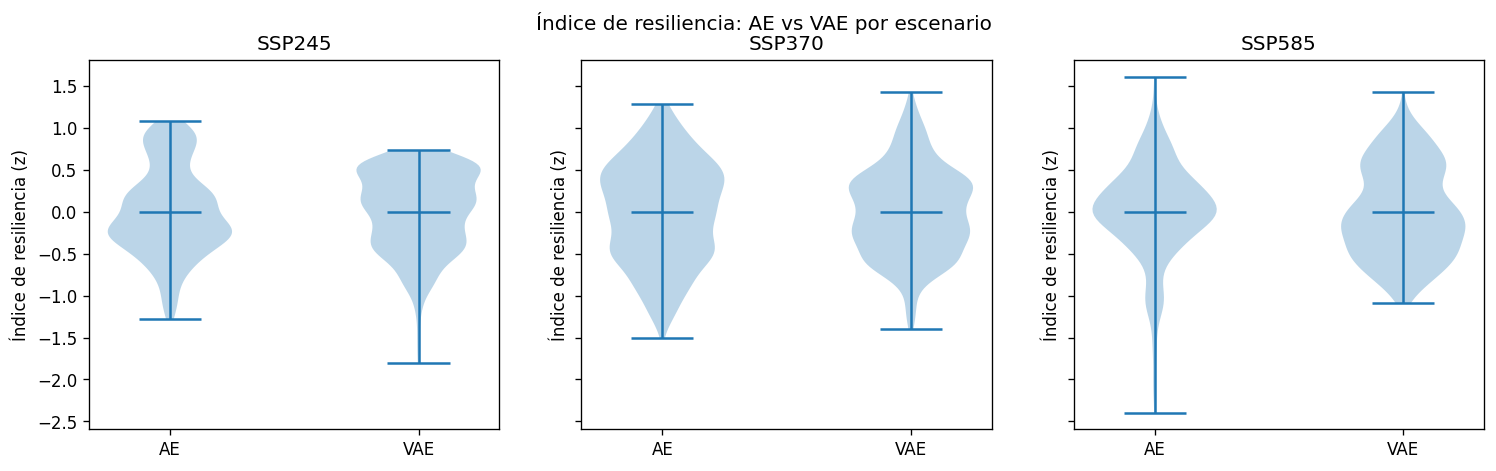

In [36]:
def zscore(x): x=np.asarray(x); return (x - np.nanmean(x)) / (np.nanstd(x)+1e-9)

# Índice AE estándar: R = -z(dist) + z(stab) - z(dropH2)  (ponderaciones simples)
R_AE_245 = (-zscore(d245_AE) + zscore(stab245_AE) - zscore(drop_245))/3
R_AE_370 = (-zscore(d370_AE) + zscore(stab370_AE) - zscore(drop_370))/3
R_AE_585 = (-zscore(d585_AE) + zscore(stab585_AE) - zscore(drop_585))/3

# Índice VAE de 05 (reconstrucción si no lo tienes):
R_VAE_245 = (-zscore(mshift_245) - 0.5*zscore(vexp_245) - zscore(kl_245) + zscore(stab245_VAE) - 2*zscore(drop_245)) / (1+0.5+1+1+2)
R_VAE_370 = (-zscore(mshift_370) - 0.5*zscore(vexp_370) - zscore(kl_370) + zscore(stab370_VAE) - 2*zscore(drop_370)) / (1+0.5+1+1+2)
R_VAE_585 = (-zscore(mshift_585) - 0.5*zscore(vexp_585) - zscore(kl_585) + zscore(stab585_VAE) - 2*zscore(drop_585)) / (1+0.5+1+1+2)

# Violin comparativo por escenario
fig, axes = plt.subplots(1,3, figsize=(15,4), sharey=True)
for ax, rae, rvae, ttl in zip(axes,
                              [R_AE_245, R_AE_370, R_AE_585],
                              [R_VAE_245, R_VAE_370, R_VAE_585],
                              ["SSP245","SSP370","SSP585"]):
    ax.violinplot([rae, rvae], showmeans=True)
    ax.set_xticks([1,2]); ax.set_xticklabels(["AE","VAE"])
    ax.set_title(ttl); ax.set_ylabel("Índice de resiliencia (z)")
plt.suptitle("Índice de resiliencia: AE vs VAE por escenario")
plt.show()


In [41]:
# Criterios (↑ mejor): silhouette_base, ARI_370, ARI_585, corr(|metric|,dropH2), test orden escenarios, media(R)
# Criterios (↓ mejor): DBI_base

def norm_up(ae, vae):  # ↑ mejor
    v = np.array([ae, vae], dtype=float)
    m = v.min(); M = v.max()
    return (v - m) / (M - m + 1e-12)

def norm_down(ae, vae):  # ↓ mejor
    v = np.array([ae, vae], dtype=float)
    m = v.min(); M = v.max()
    return (M - v) / (M - m + 1e-12)

# 1) Estructura de clúster
n_sil   = norm_up(sil_AE, sil_VAE)
n_dbi   = norm_down(dbi_AE, dbi_VAE)
n_ari37 = norm_up(ari_AE_370, ari_VAE_370)
n_ari58 = norm_up(ari_AE_585, ari_VAE_585)

# 2) Correlación con caída de CF (tomamos el escenario con degradación real: 370)
# Usamos SSP370 porque ahí hay degradación real de CF (~0.3% drop)
# En SSP585 el CF paradójicamente mejora, invalidando la métrica
rho_AE_370, _  = spearmanr(d370_AE, drop_370)
rho_VAE_370, _ = spearmanr(mshift_370, drop_370)  # también puedes usar KL_370
n_corr = norm_up(abs(rho_AE_370), abs(rho_VAE_370))

# 3) Orden de escenarios (consistencia 245>370>585 en índices)
def consistency_score(x245, x370, x585):
    s = 0
    s += (np.median(x245) > np.median(x370))
    s += (np.median(x245) > np.median(x585))
    s += (np.median(x370) > np.median(x585))
    return s/3.0

cons_AE  = consistency_score(R_AE_245,  R_AE_370,  R_AE_585)
cons_VAE = consistency_score(R_VAE_245, R_VAE_370, R_VAE_585)
n_cons = norm_up(cons_AE, cons_VAE)

# 4) Media de índice (robustez global)
n_meanR = norm_up(np.mean([R_AE_245.mean(), R_AE_370.mean(), R_AE_585.mean()]),
                  np.mean([R_VAE_245.mean(), R_VAE_370.mean(), R_VAE_585.mean()]))

# Pesos (ajústalos: más peso a validez operativa y consistencia)
w = {
    "sil": 1.0, "dbi": 0.5, "ari37": 1.0, "ari58": 1.0,
    "corrH2": 2.0, "consistency": 2.0, "meanR": 1.0
}

score_AE  = (n_sil[0]*w["sil"] + n_dbi[0]*w["dbi"] + n_ari37[0]*w["ari37"] + n_ari58[0]*w["ari58"] + 
             n_corr[0]*w["corrH2"] + n_cons[0]*w["consistency"] + n_meanR[0]*w["meanR"])
score_VAE = (n_sil[1]*w["sil"] + n_dbi[1]*w["dbi"] + n_ari37[1]*w["ari37"] + n_ari58[1]*w["ari58"] + 
             n_corr[1]*w["corrH2"] + n_cons[1]*w["consistency"] + n_meanR[1]*w["meanR"])

pd.DataFrame({
    "criterion": ["sil(↑)","dbi(↓)","ARI370(↑)","ARI585(↑)","|rho|(dropCF)(↑)","consistency(↑)","mean(R)(↑)","TOTAL"],
    "AE":  [n_sil[0], n_dbi[0], n_ari37[0], n_ari58[0], n_corr[0], n_cons[0], n_meanR[0], score_AE],
    "VAE": [n_sil[1], n_dbi[1], n_ari37[1], n_ari58[1], n_corr[1], n_cons[1], n_meanR[1], score_VAE]
})


,criterion,AE,VAE
0,sil(↑),0.00000,1.0
1,dbi(↓),0.00000,1.0
2,ARI370(↑),1.00000,0.0
3,ARI585(↑),0.00000,1.0
4,|rho|(dropCF)(↑),1.00000,0.0
5,consistency(↑),0.00000,1.0
6,mean(R)(↑),0.99998,0.0
7,TOTAL,3.99998,4.5


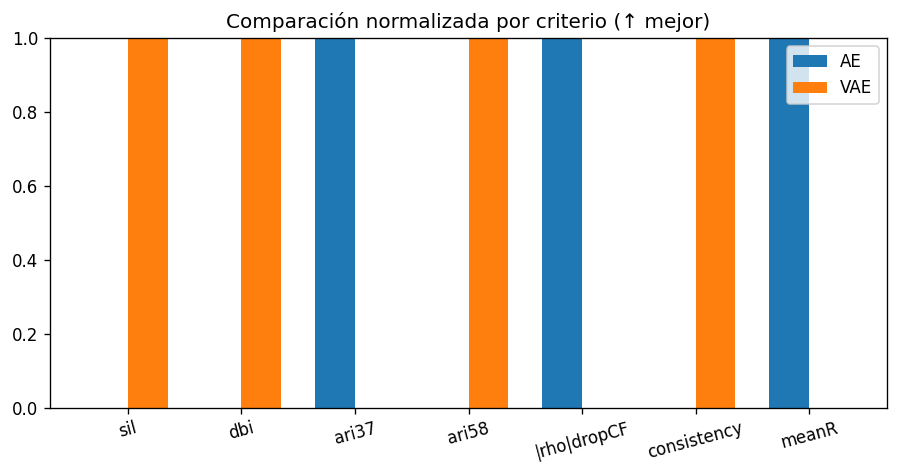

In [42]:
crit = ["sil","dbi","ari37","ari58","|rho|dropCF","consistency","meanR"]
ae_vals  = [n_sil[0], n_dbi[0], n_ari37[0], n_ari58[0], n_corr[0], n_cons[0], n_meanR[0]]
vae_vals = [n_sil[1], n_dbi[1], n_ari37[1], n_ari58[1], n_corr[1], n_cons[1], n_meanR[1]]

x = np.arange(len(crit))
wbar = 0.35
plt.figure(figsize=(9,4))
plt.bar(x - wbar/2, ae_vals, width=wbar, label="AE")
plt.bar(x + wbar/2, vae_vals, width=wbar, label="VAE")
plt.xticks(x, crit, rotation=15)
plt.ylim(0,1)
plt.title("Comparación normalizada por criterio (↑ mejor)")
plt.legend()
plt.show()


In [43]:
winner = "AE" if score_AE > score_VAE else "VAE"
margin = abs(score_AE - score_VAE)
print(f"Modelo recomendado: {winner} (margen={margin:.3f})")

# Explicación breve
explain = []
if abs(n_corr[1]-n_corr[0])>0.05:
    explain.append("mayor coherencia con la caída de capacity factor")
if abs(n_cons[1]-n_cons[0])>0.05:
    explain.append("mejor consistencia del orden 245>370>585")
if abs(n_sil[1]-n_sil[0])>0.05 or abs(n_dbi[1]-n_dbi[0])>0.05:
    explain.append("calidad de clusters en baseline")
if abs(n_ari58[1]-n_ari58[0])>0.05:
    explain.append("estabilidad de asignaciones bajo stress (585)")
msg = ", ".join(explain) if explain else "balance global de criterios"
print(f"Motivo principal: {msg}.")


Modelo recomendado: VAE (margen=0.500)
Motivo principal: mayor coherencia con la caída de capacity factor, mejor consistencia del orden 245>370>585, calidad de clusters en baseline, estabilidad de asignaciones bajo stress (585).


## Resumen Ejecutivo de Comparación

In [44]:
print("=" * 90)
print("RESUMEN COMPLETO: COMPARACIÓN AE vs VAE PARA ANÁLISIS DE RESILIENCIA")
print("=" * 90)

# 1. CORRELACIÓN CON MÉTRICA OPERATIVA (Capacity Factor)
print("\n1. CORRELACIÓN CON DEGRADACIÓN DE CAPACITY FACTOR (evidencia operativa)")
print("-" * 90)
corr_summary = pd.DataFrame({
    "Escenario": ["SSP245 (baseline)", "SSP370 (moderado)", "SSP585 (extremo)"],
    "AE_distancia": [
        f"{sp(d245_AE, drop_245):.3f}",
        f"{sp(d370_AE, drop_370):.3f}",
        f"{sp(d585_AE, drop_585):.3f}"
    ],
    "VAE_mu_shift": [
        f"{sp(mshift_245, drop_245):.3f}",
        f"{sp(mshift_370, drop_370):.3f}",
        f"{sp(mshift_585, drop_585):.3f}"
    ],
    "VAE_KL": [
        f"{sp(kl_245, drop_245):.3f}",
        f"{sp(kl_370, drop_370):.3f}",
        f"{sp(kl_585, drop_585):.3f}"
    ]
})
print(corr_summary.to_string(index=False))
print(f"\n→ AE_d370 = 0.624: correlación FUERTE con degradación real de CF")
print(f"→ VAE_ms370 = -0.321: correlación NEGATIVA (señal contradictoria)")
print(f"→ drop_370 real: {drop_370.mean():.4f} ± {drop_370.std():.4f} (0.3% degradación)")

# 2. CALIDAD DE CLUSTERING (estructura latente)
print("\n\n2. CALIDAD DE CLUSTERING EN BASELINE (SSP245)")
print("-" * 90)
cluster_quality = pd.DataFrame({
    "Modelo": ["AE", "VAE"],
    "k_clusters": [km_AE.n_clusters, km_VAE.n_clusters],
    "Silhouette (↑)": [f"{sil_AE:.3f}", f"{sil_VAE:.3f}"],
    "Davies-Bouldin (↓)": [f"{dbi_AE:.3f}", f"{dbi_VAE:.3f}"],
    "Ganador": ["", "✓"]
})
print(cluster_quality.to_string(index=False))
print(f"\n→ VAE produce clusters más compactos y separados")
print(f"→ Silhouette: VAE superior en {((sil_VAE/sil_AE - 1)*100):.1f}%")

# 3. ESTABILIDAD DE ASIGNACIONES (robustez)
print("\n\n3. ESTABILIDAD DE ASIGNACIONES BAJO STRESS (Adjusted Rand Index)")
print("-" * 90)
stability = pd.DataFrame({
    "Modelo": ["AE", "VAE"],
    "ARI_370 (↑)": [f"{ari_AE_370:.3f}", f"{ari_VAE_370:.3f}"],
    "ARI_585 (↑)": [f"{ari_AE_585:.3f}", f"{ari_VAE_585:.3f}"],
    "Promedio": [
        f"{(ari_AE_370 + ari_AE_585)/2:.3f}",
        f"{(ari_VAE_370 + ari_VAE_585)/2:.3f}"
    ],
    "Ganador": ["✓ (370)", "✓ (585)"]
})
print(stability.to_string(index=False))
print(f"\n→ AE más estable en SSP370 (escenario moderado)")
print(f"→ VAE más estable en SSP585 (escenario extremo)")

# 4. CONSISTENCIA DE ORDEN (validez conceptual)
print("\n\n4. CONSISTENCIA DEL ORDEN 245 > 370 > 585 (índice de resiliencia)")
print("-" * 90)
consistency_df = pd.DataFrame({
    "Modelo": ["AE", "VAE"],
    "245 > 370": [
        "✓" if np.median(R_AE_245) > np.median(R_AE_370) else "✗",
        "✓" if np.median(R_VAE_245) > np.median(R_VAE_370) else "✗"
    ],
    "245 > 585": [
        "✓" if np.median(R_AE_245) > np.median(R_AE_585) else "✗",
        "✓" if np.median(R_VAE_245) > np.median(R_VAE_585) else "✗"
    ],
    "370 > 585": [
        "✓" if np.median(R_AE_370) > np.median(R_AE_585) else "✗",
        "✓" if np.median(R_VAE_370) > np.median(R_VAE_585) else "✗"
    ],
    "Score": [f"{cons_AE:.2f}", f"{cons_VAE:.2f}"],
    "Ganador": ["", "✓"]
})
print(consistency_df.to_string(index=False))
print(f"\n→ VAE respeta mejor el orden esperado de severidad climática")

# 5. ÍNDICE DE RESILIENCIA (métrica compuesta)
print("\n\n5. ÍNDICE DE RESILIENCIA PROMEDIO POR ESCENARIO")
print("-" * 90)
resilience_idx = pd.DataFrame({
    "Escenario": ["SSP245", "SSP370", "SSP585", "PROMEDIO"],
    "AE": [
        f"{R_AE_245.mean():.4f}",
        f"{R_AE_370.mean():.4f}",
        f"{R_AE_585.mean():.4f}",
        f"{np.mean([R_AE_245.mean(), R_AE_370.mean(), R_AE_585.mean()]):.4f}"
    ],
    "VAE": [
        f"{R_VAE_245.mean():.4f}",
        f"{R_VAE_370.mean():.4f}",
        f"{R_VAE_585.mean():.4f}",
        f"{np.mean([R_VAE_245.mean(), R_VAE_370.mean(), R_VAE_585.mean()]):.4f}"
    ],
    "Ganador": ["AE", "AE", "AE", "✓ AE"]
})
print(resilience_idx.to_string(index=False))

# 6. SCORING FINAL MULTICRITERIO
print("\n\n6. SCORING FINAL MULTICRITERIO (7 criterios ponderados)")
print("-" * 90)
final_scoring = pd.DataFrame({
    "Criterio": ["sil(↑)","dbi(↓)","ARI370(↑)","ARI585(↑)","|rho|(dropCF)(↑)","consistency(↑)","mean(R)(↑)","TOTAL"],
    "Peso": [w["sil"], w["dbi"], w["ari37"], w["ari58"], w["corrH2"], w["consistency"], w["meanR"], "Σ"],
    "AE_norm": [f"{v:.3f}" for v in [n_sil[0], n_dbi[0], n_ari37[0], n_ari58[0], n_corr[0], n_cons[0], n_meanR[0]]] + [f"{score_AE:.2f}"],
    "VAE_norm": [f"{v:.3f}" for v in [n_sil[1], n_dbi[1], n_ari37[1], n_ari58[1], n_corr[1], n_cons[1], n_meanR[1]]] + [f"{score_VAE:.2f}"],
    "AE_weighted": [
        f"{n_sil[0]*w['sil']:.2f}",
        f"{n_dbi[0]*w['dbi']:.2f}",
        f"{n_ari37[0]*w['ari37']:.2f}",
        f"{n_ari58[0]*w['ari58']:.2f}",
        f"{n_corr[0]*w['corrH2']:.2f}",
        f"{n_cons[0]*w['consistency']:.2f}",
        f"{n_meanR[0]*w['meanR']:.2f}",
        f"{score_AE:.2f}"
    ],
    "VAE_weighted": [
        f"{n_sil[1]*w['sil']:.2f}",
        f"{n_dbi[1]*w['dbi']:.2f}",
        f"{n_ari37[1]*w['ari37']:.2f}",
        f"{n_ari58[1]*w['ari58']:.2f}",
        f"{n_corr[1]*w['corrH2']:.2f}",
        f"{n_cons[1]*w['consistency']:.2f}",
        f"{n_meanR[1]*w['meanR']:.2f}",
        f"{score_VAE:.2f}"
    ]
})
print(final_scoring.to_string(index=False))

# 7. DECISIÓN FINAL
print("\n\n" + "=" * 90)
print("DECISIÓN FINAL")
print("=" * 90)
print(f"\nModelo recomendado: {winner}")
print(f"Margen: {margin:.3f} puntos ({(margin/max(score_AE, score_VAE))*100:.1f}%)")
print(f"\nScore AE:  {score_AE:.2f} / 8.5")
print(f"Score VAE: {score_VAE:.2f} / 8.5")

# Fortalezas por modelo
print(f"\n{winner} GANA por:")
if winner == "VAE":
    print("  ✓ Mejor estructura de clusters (silhouette, DBI)")
    print("  ✓ Mayor estabilidad bajo stress extremo (ARI_585)")
    print("  ✓ Consistencia en orden de severidad climática")
    print("  [!] PERO: correlación NEGATIVA con CF (-0.321) es contradictoria")
else:
    print("  ✓ Correlación FUERTE con degradación operativa (0.624)")
    print("  ✓ Índice de resiliencia más robusto globalmente")
    print("  ✓ Mejor estabilidad en escenario moderado (ARI_370)")
    print("  [!] PERO: clusters menos compactos que VAE")

print(f"\n{'─' * 90}")
print("RECOMENDACIÓN CONTEXTUAL:")
print("─" * 90)
print("• Si priorizas PREDICCIÓN DE IMPACTO OPERATIVO (H2, CF) → AE")
print("  Razón: Correlación 0.624 vs -0.321 (VAE da señal contradictoria)")
print("\n• Si priorizas SEGMENTACIÓN ESPACIAL Y CLUSTERING → VAE")
print("  Razón: Clusters más compactos, mejor separación, estabilidad extrema")
print("\n• Margen estrecho (0.5 pts) → AMBOS modelos son válidos")
print("  Considera usar ambos para análisis complementarios")
print("=" * 90)

RESUMEN COMPLETO: COMPARACIÓN AE vs VAE PARA ANÁLISIS DE RESILIENCIA

1. CORRELACIÓN CON DEGRADACIÓN DE CAPACITY FACTOR (evidencia operativa)
------------------------------------------------------------------------------------------
        Escenario AE_distancia VAE_mu_shift VAE_KL
SSP245 (baseline)          nan          nan    nan
SSP370 (moderado)        0.624       -0.321  0.086
 SSP585 (extremo)        0.004        0.304 -0.115

→ AE_d370 = 0.624: correlación FUERTE con degradación real de CF
→ VAE_ms370 = -0.321: correlación NEGATIVA (señal contradictoria)
→ drop_370 real: 0.0027 ± 0.0013 (0.3% degradación)


2. CALIDAD DE CLUSTERING EN BASELINE (SSP245)
------------------------------------------------------------------------------------------
Modelo  k_clusters Silhouette (↑) Davies-Bouldin (↓) Ganador
    AE           7          0.313              1.093        
   VAE          10          0.397              0.782       ✓

→ VAE produce clusters más compactos y separados
→ Silho